In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Combine all the dataframes for training
df_train = pd.DataFrame()

# Combine the dataframes
for filename in listdir("dataset\\dataset\\train\\boxes_transcripts_labels\\"):
    df_temp = pd.read_csv("dataset\\dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']
    #df_temp_trimmed = df_temp.loc[df_temp['field'] != 'OTHER']

    df_train = pd.concat([df_train, df_temp], ignore_index = True)

In [48]:
# Now we build the model and the preprocessing functions based on our analysis
def Feature_Engineering(df):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']

    # We select 5 features told to us by RFECV and the label
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len', 'field']]

    return df

def X_y_split(df):
    y = df[['field']]
    X = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
    return X,y

def Hierarchical_Training(df, model1, model2):
    df1 = Feature_Engineering(df)
    df2 = df1.copy()

    # For 1st model, we convert relevant columns as "not other"  & We reduce the number of "OTHER" columns to reduce skewness
    df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    X1,y1 = X_y_split(df1)
    resampled_X1, resampled_y1 = rus.fit_resample(X1,y1)

    model1 = model1.fit(resampled_X1, resampled_y1.values.ravel())


    # For 2nd model, we simply drop all rows with 'OTHER' as label
    df2 = df2.loc[df2['field'] != 'OTHER']
    X2,y2 = X_y_split(df2)

    model2 = model2.fit(X2, y2.values.ravel())

    return model1, model2


def Testing(df, model1, model2):
    df1 = Feature_Engineering(df)
    X_test, y_test = X_y_split(df1)

    main_pred = []

    # Making separate y to compare for model1 and 2
    y_test1 = y_test.copy()
    y_test1.loc[y_test1["field"] != "OTHER", "field"] = 'NOT_OTHER'

    y_pred1 = model1.predict(X_test)

    cm_other = confusion_matrix(y_test1, y_pred1)

    y_pred2 = model2.predict(X_test)
    
    # Combining the two results to get the original result.
    for i in range(len(y_pred1)):
        if y_pred1[i] != 'OTHER': main_pred.append(y_pred2[i])
        else: main_pred.append(y_pred1[i])
    
    cm_main = confusion_matrix(y_test, y_pred1)

    return cm_main, cm_other


In [8]:
n = 200 # Obtained from model analysis

model1 = RandomForestClassifier(n_estimators = n, verbose=1)
model2 = RandomForestClassifier(n_estimators = n, verbose=1)

model1, model2 = Hierarchical_Training(df_train, model1, model2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   16.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.7s


In [12]:
# Get testing dataframes
# for filename in listdir("dataset\\dataset\\val_w_ann\\boxes_transcripts_labels"):
df_test = pd.read_csv("dataset\\dataset\\val_w_ann\\boxes_transcripts_labels\\0b55f878-9dc7-478b-9bba-342056684452_document-1_page-1.tsv", sep = ',', header = None)
df_test.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']

In [49]:
cm_main, cm_other = Testing(df_test, model1, model2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


array([[ 24,   0],
       [  0, 163]], dtype=int64)

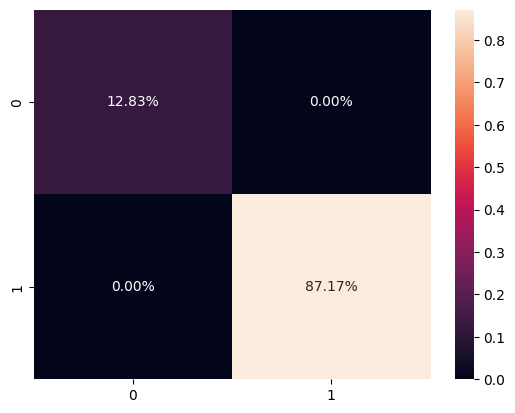

In [52]:
sns.heatmap(cm_other/np.sum(cm_other), annot=True, fmt='.2%')
cm_other

In [54]:
cm_sum = 0
for i in range(len(cm_main)):
    cm_sum += cm_main[i][i]
acc = cm_sum/np.sum(cm_main)
acc

0.8716577540106952